# Prediction Algorithms

## Preliminaries

In [1]:
import os
import sys
import networkx as nx
import numpy as np

from functools import reduce
from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import copy

import morpheus
from morpheus.utils.encoding import code_to_query
from morpheus.algo.selection import base_selection_algorithm
from morpheus.tests import (default_chain,
                            default_ensemble,
                            default_dataset,
                            default_m_list_for_mercs,
                            random_m_list_for_mercs)

from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format,
                            add_imputation_nodes,
                            add_merge_nodes)


In [2]:
def fix_layout(G):
    
    for n in G.nodes():
        node = G.nodes(data=True)[n]
        if node['bipartite'] == 'func':
            node['shape'] = "\"square\""
            node['width'] = "1"
        elif node['bipartite'] == 'data':
            node['shape'] = "\"circle\""
        else:
            pass
    
    return G

## Collect Basic Building Blocks

In [3]:
data, _ = default_dataset()
data = data.values
m_list = default_m_list_for_mercs(data)

Gs = [model_to_graph(m, idx) for idx, m in enumerate(m_list)]
Gs = [fix_layout(g) for g in Gs]
G = reduce(nx.compose, Gs)


        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 7]
                            targ ids:    [6]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 6]
                            targ ids:    [7]
        

        Learning model with desc ids:    [0, 2, 3, 4, 5, 6, 7]
                            targ ids:    [1]
        

        Learning model with desc ids:    [1, 2, 3, 4, 5, 6, 7]
                            targ ids:    [0]
        

        Learning model with desc ids:    [0, 1, 2, 3, 5, 6, 7]
                            targ ids:    [4]
        

        Learning model with desc ids:    [0, 1, 3, 4, 5, 6, 7]
                            targ ids:    [2]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 6, 7]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 2, 4, 5, 6, 7]
                            targ ids:    [3]
        


## MI

In [4]:
def mi_algorithm(g_list, q_code):
    
    q_desc, q_targ, q_miss = code_to_query(q_code)
    
    def criterion(g):
        outputs = set([g.nodes()[node]['idx'] for node, out_degree in g.out_degree()
                       if out_degree == 0
                       if g.nodes()[node]['kind']=='data'])
        
        
        return len(set(q_targ).intersection(outputs)) > 0
    
    g_relevant = [g for g in g_list if criterion(g)]
    g_relevant = [copy.deepcopy(g) for g in g_relevant]
    
    
    g_relevant = [add_imputation_nodes(g, q_desc) for g in g_relevant]
    
    
    result = reduce(nx.compose, g_relevant)
    
    return result

In [5]:
g_list = Gs
q_code = np.array([0,0,0,0,0,-1,1,1])
g_res = mi_algorithm(g_list, q_code)

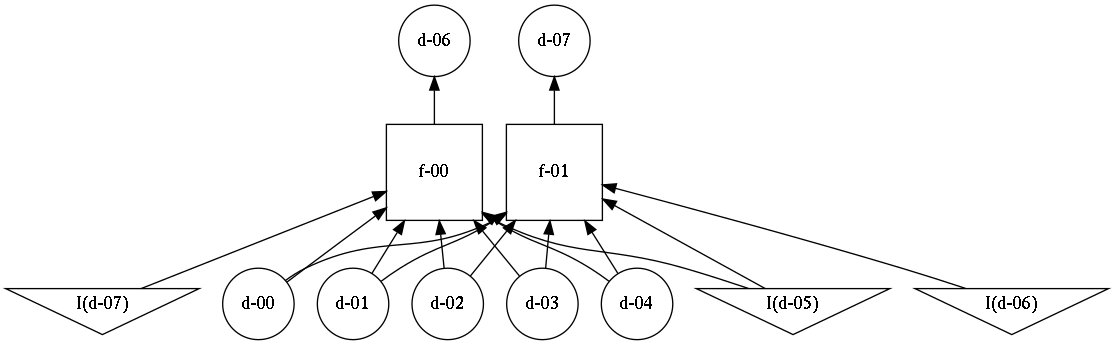

In [6]:
# Plot
X = to_pydot(g_res)
X.set('rankdir', 'BT')
#X.set('splines', 'ortho')

with open("tmp/mi.dot", "w") as text_file:
    print(X.to_string(), file=text_file)

!dot -T png ./tmp/mi.dot > ./tmp/mi.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/mi.png', unconfined=True))

## MA-algorithm

In [7]:
def ma_algorithm(g_list, q_code, init_threshold=1.0, stepsize=0.1):
    
    q_desc, q_targ, q_miss = code_to_query(q_code)
    
    def criterion(g):
        inputs = set([g.nodes()[node]['idx']
                      for node, in_degree in g.in_degree()
                      if in_degree == 0
                      if g.nodes()[node]['kind']=='data'])
        
        outputs = set([g.nodes()[node]['idx']
                       for node, out_degree in g.out_degree()
                       if out_degree == 0
                       if g.nodes()[node]['kind']=='data'])
        
        yes_no = len(set(q_targ).intersection(outputs)) > 0
        
        quantifier = len(set(q_desc).intersection(inputs))/len(inputs)
        
        result = int(yes_no) * quantifier
        
        msg = """
        yes_no:       {}
        quantifier:   {}
        result:       {}
        """.format(yes_no, quantifier, result)
        print(msg)
        
        return result
    
    
    thresholds = np.clip(np.arange(init_threshold, -stepsize, -stepsize), 0, 1)
    
    for thr in thresholds:
        g_relevant = [g for g in g_list if criterion(g) > thr]
        if len(g_relevant) > 0:
            print('we have found a model at threshold: {}'.format(thr))
            break
    
    g_relevant = [copy.deepcopy(g) for g in g_relevant]
    g_relevant = [add_imputation_nodes(g, q_desc) for g in g_relevant]
    result = reduce(nx.compose, g_relevant)
    
    add_merge_nodes(result)
    
    return result

In [8]:
m_list = random_m_list_for_mercs(data)
m_list += random_m_list_for_mercs(data)

Gs = [model_to_graph(m, idx) for idx, m in enumerate(m_list)]
Gs = [fix_layout(g) for g in Gs]


        Learning model with desc ids:    [0, 1, 3, 4]
                            targ ids:    [7]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 7]
                            targ ids:    [6]
        

        Learning model with desc ids:    [2, 3, 4, 6]
                            targ ids:    [5]
        

        Learning model with desc ids:    [2, 3, 4, 5, 6, 7]
                            targ ids:    [1]
        

        Learning model with desc ids:    [1, 2, 3, 5, 6, 7]
                            targ ids:    [4]
        

        Learning model with desc ids:    [4, 5, 7]
                            targ ids:    [0]
        

        Learning model with desc ids:    [0, 1, 3, 4, 5]
                            targ ids:    [2]
        

        Learning model with desc ids:    [0, 1, 2, 4, 5, 7]
                            targ ids:    [3]
        

        Learning model with desc ids:    [1, 3, 4]
                            targ ids:    [6]
    

In [9]:
q_code = np.array([-1,0,0,0,0,-1,1,0])
g_res = ma_algorithm(Gs, q_code, init_threshold = 1)


        yes_no:       False
        quantifier:   0.75
        result:       0.0
        

        yes_no:       True
        quantifier:   0.7142857142857143
        result:       0.7142857142857143
        

        yes_no:       False
        quantifier:   0.75
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6666666666666666
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6666666666666666
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6666666666666666
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6666666666666666
        result:       0.0
        

        yes_no:       True
        quantifier:   1.0
        result:       1.0
        

        yes_no:       False
        quantifier:   0.6666666666666666
        result:       0.0
    

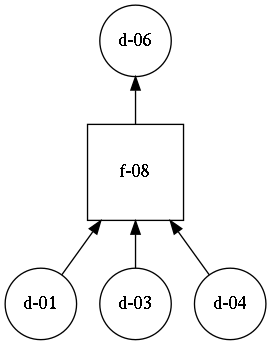

In [10]:
# Plot
X = to_pydot(g_res)
X.set('rankdir', 'BT')
#X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)

!dot -T png ./tmp/test.dot > ./tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

## MRAI

In [11]:
def mrai_algorithm(g_list, q_code, init_threshold=1.0, stepsize=0.1):
    
    q_desc, q_targ, q_miss = code_to_query(q_code)
    
    def criterion(g):        
        outputs = set([g.nodes()[node]['idx']
                       for node, out_degree in g.out_degree()
                       if out_degree == 0
                       if g.nodes()[node]['kind']=='data'])
        
        yes_no = len(set(q_targ).intersection(outputs)) > 0
        
        feature_importances_available = [g.nodes()[node]['fi']
                                         for node, in_degree in g.in_degree()
                                         if in_degree == 0
                                         if g.nodes()[node]['kind']=='data'
                                         if g.nodes()[node]['idx'] in q_desc]
        
        quantifier = np.sum(feature_importances_available)
        
        result = int(yes_no) * quantifier
        
        msg = """
        yes_no:       {}
        quantifier:   {}
        result:       {}
        """.format(yes_no, quantifier, result)
        print(msg)
        
        return result
    
    
    thresholds = np.clip(np.arange(init_threshold, -stepsize, -stepsize), 0, 1)
    
    for thr in thresholds:
        g_relevant = [g for g in g_list if criterion(g) > thr]
        if len(g_relevant) > 0:
            print('we have found a model at threshold: {}'.format(thr))
            break
    
    g_relevant = [copy.deepcopy(g) for g in g_relevant]
    g_relevant = [add_imputation_nodes(g, q_desc) for g in g_relevant]
    result = reduce(nx.compose, g_relevant)
    
    add_merge_nodes(result)
    
    return result

In [12]:
q_code = np.array([-1,0,0,0,0,-1,1,0])
g_res = mrai_algorithm(Gs, q_code, init_threshold = 1, stepsize=0.01)


        yes_no:       False
        quantifier:   0.8550067982503414
        result:       0.0
        

        yes_no:       True
        quantifier:   0.7798300305533896
        result:       0.7798300305533896
        

        yes_no:       False
        quantifier:   0.7478153728453558
        result:       0.0
        

        yes_no:       False
        quantifier:   0.8486196308039193
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6949150786064824
        result:       0.0
        

        yes_no:       False
        quantifier:   0.6871066627549756
        result:       0.0
        

        yes_no:       False
        quantifier:   0.5652741769377216
        result:       0.0
        

        yes_no:       False
        quantifier:   0.7004817622380914
        result:       0.0
        

        yes_no:       True
        quantifier:   0.9999999999999999
        result:       0.9999999999999999
        

        yes_no:       Fals

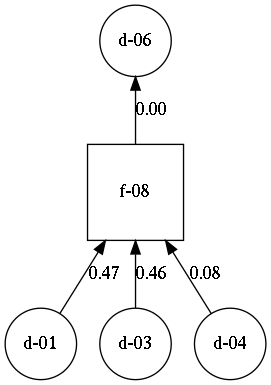

In [13]:
for e in g_res.edges():
    g_res.edges()[e]['label'] = "{0:.2f}".format(g_res.edges()[e].get('fi', 0))

# Plot
X = to_pydot(g_res)
X.set('rankdir', 'BT')
#X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)

!dot -T png ./tmp/test.dot > ./tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

In [14]:
g_extra = Gs[15].copy()
g_extra.nodes()['d-05']['fi'] = g_extra.nodes()['d-05']['fi'] - 0.2
g_extra.nodes()['d-03']['fi'] = g_extra.nodes()['d-03']['fi'] + 0.2

Gs[15].nodes()['d-05']

{'bipartite': 'data',
 'kind': 'data',
 'idx': 5,
 'tgt': [5],
 'fi': 0.3180332246079355,
 'shape': '"circle"'}

In [15]:
g_extra.nodes()['f-15'].rename('x')

AttributeError: 'dict' object has no attribute 'rename'

In [ ]:
g_extra.nodes()['d-05']

In [ ]:
Gs.append(g_extra)